<a href="https://colab.research.google.com/github/thayeylolu/cyberbullying/blob/main/notebooks/CountVectorizer_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

%matplotlib inline

## Mount Drive to connect data present in google drive

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Read CSV 

In [ ]:
df = pd.read_csv('/drive/MyDrive//NLP/train_data.csv')

## Load information about the Dataset and preview the first 5 rows

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          47692 non-null  int64 
 1   clean_txt_emoji     47692 non-null  object
 2   cyberbullying_type  47692 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


,Unnamed: 0,clean_txt_emoji,cyberbullying_type
0,0,words food crapilicious katandandre mkr,not_cyberbullying
1,1,white aussietv MKR theblock ImACelebrityAU tod...,not_cyberbullying
2,2,classy whore red velvet cupcakes,not_cyberbullying
3,3,meh thanks heads concerned another angry dude ...,not_cyberbullying
4,4,isis account pretending kurdish account like i...,not_cyberbullying


### Data Cleaning

- Strip white spaces in the `clean_txt_emoji` column 
- Drop empty rows and `Unnamed: 0` column
- Select `cyberbullying_type` and `clean_txt_emoji`
- Split the data into test , validate and train dataset that and set a random state for the split
- Check the value count for each classes

In [ ]:

df['clean_txt_emoji'] = df['clean_txt_emoji'].str.strip()
df = df.dropna()
df = df.drop(columns = ["Unnamed: 0"])
# still need to  remove empty space or trim each clean_txt_emoji

#df['cyberbullying_type'] = df['cyberbullying_type'].apply(encode_label)
df = df[['cyberbullying_type', 'clean_txt_emoji']]
df['clean_txt_emoji']

train, test_valid = train_test_split(df,train_size= 0.70, random_state= 3040)
test, valid = train_test_split(test_valid,train_size= .50, random_state= 3040)
test['cyberbullying_type'].value_counts()

religion               1238
not_cyberbullying      1232
gender                 1214
ethnicity              1197
age                    1167
other_cyberbullying    1106
Name: cyberbullying_type, dtype: int64

### Encode the labels into numerical labels

In [ ]:
classes = df['cyberbullying_type'].unique()

encoder = LabelEncoder()
y = encoder.fit_transform(df['cyberbullying_type'])

### Split train, test and validate data into X and y

In [ ]:
X_train, y_train = train.drop(columns=["cyberbullying_type"]), train["cyberbullying_type"]
X_test, y_test = test.drop(columns=["cyberbullying_type"]), test["cyberbullying_type"]
X_val, y_valid =  valid.drop(columns=["cyberbullying_type"]),valid["cyberbullying_type"]

## Define a Count Vectorizer

- Save the train_X data as the corpus to train the vecotrizer on
- Initialize the count vectorizer
- Fit and transformer the train data on the vecotrizer
-  extract feature vectors

In [ ]:

corpus_train = X_train['clean_txt_emoji']
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(corpus_train)
feat_names = vectorizer.get_feature_names_out()
feat_names.shape
X_train_vec.shape

(33384, 33769)

## Transform Valid and Test Data

- Transformer the validate and test corpus data on the vecotrizer
- extract feature vectors

In [ ]:
corpus_val = X_val['clean_txt_emoji']
X_valid_vec = vectorizer.transform(corpus_val)
feat_names = vectorizer.get_feature_names_out()
print(X_valid_vec.shape)

X_test_vec = vectorizer.transform(X_test['clean_txt_emoji'])
feat_names = vectorizer.get_feature_names_out()
print(X_test_vec.shape)

(7154, 33769)
(7154, 33769)


## Model Selection 
Code adopted from Vecotr AI institute Assignment 4 notebook
- The function loops over the a series of `depth` to find the best hyperparameter to train the decision tree classfier on.

- For each depth, the validation score, train score and model is stored in a dictionary



In [ ]:

## Code adopted from Vecotr AI institute Assignment 4 notebook

def select_model(depths, train_X, train_y, val_X, val_y, criteria):
    out = {}
    for dep in depths:
        # Evaluating on depth
        out[dep] = {}

        tree = DecisionTreeClassifier(criterion=criteria, max_depth=dep)
        tree = tree.fit(train_X, train_y)

        # Evaluating the model in the train and val datasets
        out[dep]['val'] = tree.score(val_X, val_y)
        out[dep]['train'] = tree.score(train_X, train_y)
        out[dep]['model'] = tree
    return out



## Finding the best model
Code adopted from Vecotr AI institute Assignment 4 notebook
- loop through different types and sizes of decision tree to find best performer based on the accuracy of the validation score
- Store the best model parameters and score in the `best_model` 


In [ ]:
# loop through different types and sizes of decision tree to find best performer

best_model = {}
for criterion in ("entropy", "gini"):
    print("\nUsing criterion {}".format(criterion))
    res = select_model(range(5, 95, 5), X_train_vec, y_train, X_valid_vec, y_valid, criterion)
    best_d = None
    best_acc = 0
    for d in res:
        val_acc = res[d]['val']
        print("Depth: {}   Train: {}    Val: {}".format(d, res[d]['train'], val_acc))

        if val_acc > best_acc:
            best_d = d
            best_acc = val_acc

    test_score = res[best_d]['model'].score(X_test_vec, y_test)

    
    best_model[criterion] = [best_d , test_score]
    print("Best depth: {}    Test: {}".format(best_d, test_score))


Using criterion entropy
Depth: 5   Train: 0.5833632878025401    Val: 0.5802348336594912
Depth: 10   Train: 0.6892822909178049    Val: 0.6875873637126083
Depth: 15   Train: 0.7654864605799185    Val: 0.762510483645513
Depth: 20   Train: 0.7989156482147136    Val: 0.787950796757059
Depth: 25   Train: 0.8268631679846633    Val: 0.8103159071847917
Depth: 30   Train: 0.8371675053918045    Val: 0.812971764048085
Depth: 35   Train: 0.8434279894560268    Val: 0.815068493150685
Depth: 40   Train: 0.8542115983704769    Val: 0.8216382443388314
Depth: 45   Train: 0.8610412173496286    Val: 0.8234554095610848
Depth: 50   Train: 0.8681703810208483    Val: 0.8241543192619514
Depth: 55   Train: 0.8732925952552121    Val: 0.8249930109029914
Depth: 60   Train: 0.8775161754133717    Val: 0.8276488677662845
Depth: 65   Train: 0.8815600287562905    Val: 0.8254123567235113
Depth: 70   Train: 0.8850946561226936    Val: 0.8255521386636846
Depth: 75   Train: 0.8882099209202013    Val: 0.8263908303047246
Depth

## Select the model parameters with highest accuracy

In [ ]:
best_model

{'entropy': [60, 0.8139502376292983], 'gini': [60, 0.8126922001677384]}

In [ ]:

train_params= max([(value, key) for key, value in best_model.items()])
train_params


([60, 0.8139502376292983], 'entropy')

## Train the Decision Tree with the parameters
- Triains the model on the best hyper parameters
- Predicts the test

In [ ]:
# The best performing decision tree was depth 55 with gini criterion so check its confusion matrix
best_tree = DecisionTreeClassifier(criterion=train_params[1], max_depth=train_params[0][0])
best_tree = best_tree.fit(X_train_vec, y_train)
y_test_predicted = best_tree.predict(X_test_vec)


## Generate a Confusion Matrix

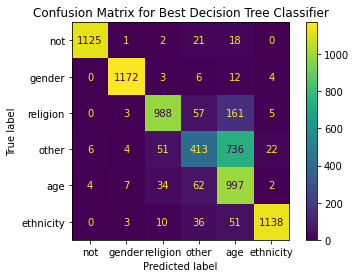

In [ ]:
# Generate a more visual representation of the confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_predicted, labels=best_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not', 'gender', 'religion', 'other', 'age', 'ethnicity'])
disp.plot()
plt.title("Confusion Matrix for Best Decision Tree Classifier")
plt.show()

### Evaluating Models Performance 


In [ ]:
test['predicition']= y_test_predicted
test

,cyberbullying_type,clean_txt_emoji,prediciton,predicition
24614,other_cyberbullying,wow fucking douche going hit hot even fucking ...,other_cyberbullying,other_cyberbullying
27520,other_cyberbullying,get raped drunk BlameOneNotAll YouKnowWhatMenA...,other_cyberbullying,other_cyberbullying
15706,gender,sure calls female workers fucking bitch time,gender,gender
41425,ethnicity,tell stupid ass fucks yur btwn yrs yur man sti...,ethnicity,ethnicity
25557,other_cyberbullying,idiots believe insecticides harmless world gon...,other_cyberbullying,other_cyberbullying
...,...,...,...,...
15804,gender,think casually make jokes speak illy discredit...,gender,gender
34856,age,one time girl bullied high school said ugly fu...,age,age
10308,gender,never call bad bitch aint worried bout trends ...,gender,gender
27476,other_cyberbullying,,other_cyberbullying,other_cyberbullying


In [ ]:
test[test.predicition != test.cyberbullying_type]

,cyberbullying_type,clean_txt_emoji,prediciton,predicition
15087,gender,mkr,not_cyberbullying,not_cyberbullying
28219,other_cyberbullying,bullying giant wasp mean,not_cyberbullying,not_cyberbullying
33390,age,school fag,not_cyberbullying,not_cyberbullying
26056,other_cyberbullying,dad fake fooling public screwing folks literal...,age,age
881,not_cyberbullying,lol you worries one safe ones,other_cyberbullying,other_cyberbullying
...,...,...,...,...
7282,not_cyberbullying,new rule old rule cannot leader movement oppre...,other_cyberbullying,other_cyberbullying
5274,not_cyberbullying,people like give feminists bad name wrong best...,gender,gender
19069,religion,three translations quran microbrain know far i...,not_cyberbullying,not_cyberbullying
2003,not_cyberbullying,amazing awesome folks emailed regrouping discu...,other_cyberbullying,other_cyberbullying


### Conclusion 

- The Decision Tree Predicts a total of 1321 rows incorrectly
